# Cloud Cost Anomaly Detection & Forecasting Using Data Analytics

* With enterprises rapidly scaling their operations on cloud platforms (AWS, Azure, GCP), cloud bills have become a major controllable cost factor. Many IT companies face:  
    * Unexpected spikes in usage leading to surprise bills.
    * Underutilized or idle resources consuming budget.
    * Anomalies caused by misconfigurations, attacks, or runaway jobs.
* Business leaders (CFOs, CTOs, Engineering Managers) need data-driven visibility into usage and spend patterns to forecast budgets accurately, detect anomalies early, and enforce governance.
* This project’s objective is to demonstrate how data analytics can reduce waste, improve efficiency, and prevent unexpected cloud overspend.

**Business Problem**
* Cloud cost overruns and anomalies lead to:
    * 20–40% overspending annually due to lack of governance and transparency.
    * Difficulty identifying which team/service/region caused the spike.
    * Inability to predict future spend accurately, leading to budget shocks.
    * SLA breaches when anomalies impact customer-facing workloads.
* Without robust anomaly detection and forecasting, IT companies lose millions and undermine operational efficiency.

**Goal**
* To build an end-to-end analytics solution that:
    * Detects and flags anomalous cloud spending in near real-time.
    * Forecasts future spend using statistical and machine learning models.
    * Identifies cost-saving opportunities by analyzing underutilized resources.
    * Provides actionable dashboards for both executives (strategic view) and engineers (operational root-cause analysis).

## Forecasting Cloud Costs

### Importing Libaries + Loading Dataset

In [2]:
!pip install prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
    --------------------------------------- 0.3/13.3 MB ? eta -:--:--
   -- ------------------------------------- 0.8/13.3 MB 1.7 MB/s eta 0:00:08
   --- ------------------------------------ 1.3/13.3 MB 1.8 MB/s eta 0:00:07
   ---- ----------------------------------- 1.6/13.3 MB 1.8 MB/s eta 0:00:07
   ----- ---------------------------------- 1.8/13.3 MB 1.8 MB/s eta 0:00:07
   ------- -------------------------------- 2.4/13.3 MB 1.9 MB/s eta 0:00:06
   -------- ------------------------------- 2.9/13.3 MB 1.9 MB/s eta 0:00:06
   --------- ------------------------------ 3.1/13.3 MB 1.9 MB/s eta 0:00:06
   ----------- ---------------------------- 3.7/13.3 MB 1.9 MB/s eta 0:00:06
   ----------- ---------------------------- 3.9/13.3 MB 1.9 MB/s eta 0:00:06
   ------------- -------------------------- 4.5/13.3 MB 1.9 MB/s eta 0:00:05
   -------------- ------------------------- 4.7/13.3 MB 1.9 MB/s eta 0:00:05
   ----------

In [15]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plot

In [4]:
df = pd.read_parquet('clean_cloud_data.parquet')

In [5]:
df.head(10)

,timestamp,resource_id,service_tag,service_canonical,region,team,instance_type,usage,usage_unit,cost_usd,currency,owner,source_ip,cost_imputed_flag,is_outlier
0,2024-10-10 06:32:31.665035,9f546ae5,S3,S3,us-west-2,search,t3.medium,1.294475,GB-hours,3.660000e-06,USD,udavis,210.90.217.45,False,False
1,2025-06-08 02:19:47.665035,78e0807a,EC2,EC2,us-west-2,search,m5.large,5.549555,vCPU-hours,2.774778e-01,USD,mrosario,22.219.141.112,True,True
2,2025-07-26 04:59:10.665035,cf9713a0,EC2,EC2,eu-west-1,infra,m5.large,11.416323,vCPU-hours,5.059163e-01,USD,cjackson,208.132.8.249,False,True
3,2025-08-31 21:54:40.665035,71c42bb1,EC2,EC2,eu-west-1,Unknown,spot-small,0.479407,vCPU-hours,3.400440e-04,USD,harringtontimothy,49.94.27.144,False,False
4,2025-03-10 12:51:34.665035,5ddba1b8,EBS,EBS,ap-south-1,Unknown,r5.large,21.487007,GB-hours,1.270440e-04,USD,jason04,122.212.132.65,False,False
5,2025-09-19 16:15:57.665035,e1eb527d,ELB,ELB,eu-west-1,payments,spot-small,124.000000,requests,1.380984e-03,USD,walterherrera,27.143.221.40,False,False
6,2025-04-05 08:24:31.665035,a2ec574d,Lambda,Lambda,ap-south-1,payments,c5.xlarge,383.042823,requests,7.560000e-07,USD,connorhardy,182.213.230.111,False,False
7,2025-01-17 03:38:18.665035,16aa964c,Lambda,Lambda,eu-west-1,search,r5.large,191.000000,requests,4.000000e-05,USD,charles65,205.9.71.87,False,False
8,2025-08-03 22:09:36.665035,b609411d,RDS,RDS,us-east-1,devtools,c5.xlarge,0.535388,vCPU-hours,4.940520e-04,USD,james16,45.27.149.136,False,False
9,2025-04-15 18:15:01.665035,d0a92372,CloudFront,CloudFront,us-east-1,payments,t3.medium,21.101344,GB-hours,2.956800e-05,USD,thompsondeanna,57.239.87.105,False,False


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990024 entries, 0 to 990023
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   timestamp          990024 non-null  datetime64[ns]
 1   resource_id        990024 non-null  string        
 2   service_tag        990024 non-null  string        
 3   service_canonical  990024 non-null  object        
 4   region             990024 non-null  string        
 5   team               990024 non-null  string        
 6   instance_type      990024 non-null  string        
 7   usage              990024 non-null  float64       
 8   usage_unit         990024 non-null  object        
 9   cost_usd           990024 non-null  float64       
 10  currency           990024 non-null  object        
 11  owner              990024 non-null  string        
 12  source_ip          990024 non-null  string        
 13  cost_imputed_flag  990024 non-null  bool    

In [7]:
# aggregating to daily total spend

agg_daily = df.groupby(df['timestamp'].dt.date)['cost_usd'].sum().reset_index()

In [9]:
# Prophet requires two columns: ds for date and y as a value to forecast as we are modeling total daily spend

agg_daily.columns = ['ds', 'y']
agg_daily['ds'] = pd.to_datetime(agg_daily['ds'])
agg_daily.head()

,ds,y
0,2024-09-24,171.741526
1,2024-09-25,396.065590
2,2024-09-26,323.461202
3,2024-09-27,333.849789
4,2024-09-28,362.647824


In [10]:
# Adding regressors

agg_daily['is_weekend'] = (agg_daily['ds'].dt.weekday > 5).astype(int)
agg_daily['is_month_end'] = agg_daily['ds'].dt.is_month_end.astype(int)

# These will capture calendar driven effects as costs often dip on weekends and spike at month-end due to batch jobs or billing runs

In [11]:
agg_daily.head()

,ds,y,is_weekend,is_month_end
0,2024-09-24,171.741526,0,0
1,2024-09-25,396.065590,0,0
2,2024-09-26,323.461202,0,0
3,2024-09-27,333.849789,0,0
4,2024-09-28,362.647824,0,0


In [12]:
# Building prophet model

m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m.add_regressor('is_weekend')
m.add_regressor('is_month_end')

m.fit(agg_daily)

# Weekly seasonality will compare weekday vs. weekend
# Yearly seasonality captures long terms effects in a year of data
# Regressors will capture business driven effects

06:05:12 - cmdstanpy - INFO - Chain [1] start processing
06:05:12 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
# Forecasting for 30 days

future = m.make_future_dataframe(periods=30)
future['is_weekend'] = (future['ds'].dt.weekday > 5).astype(int)
future['is_month_end'] = future['ds'].dt.is_month_end.astype(int)

forecast = m.predict(future)

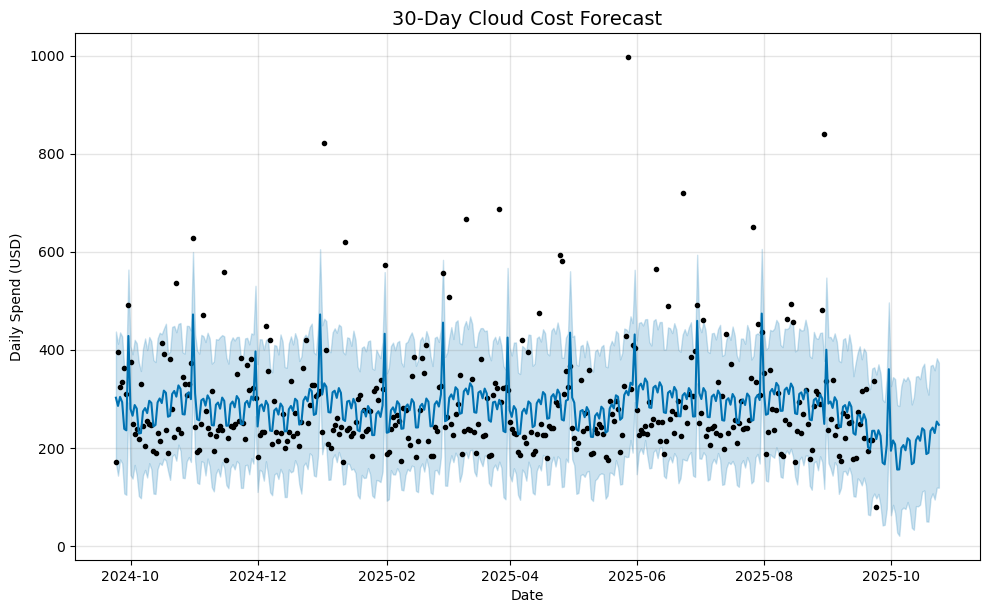

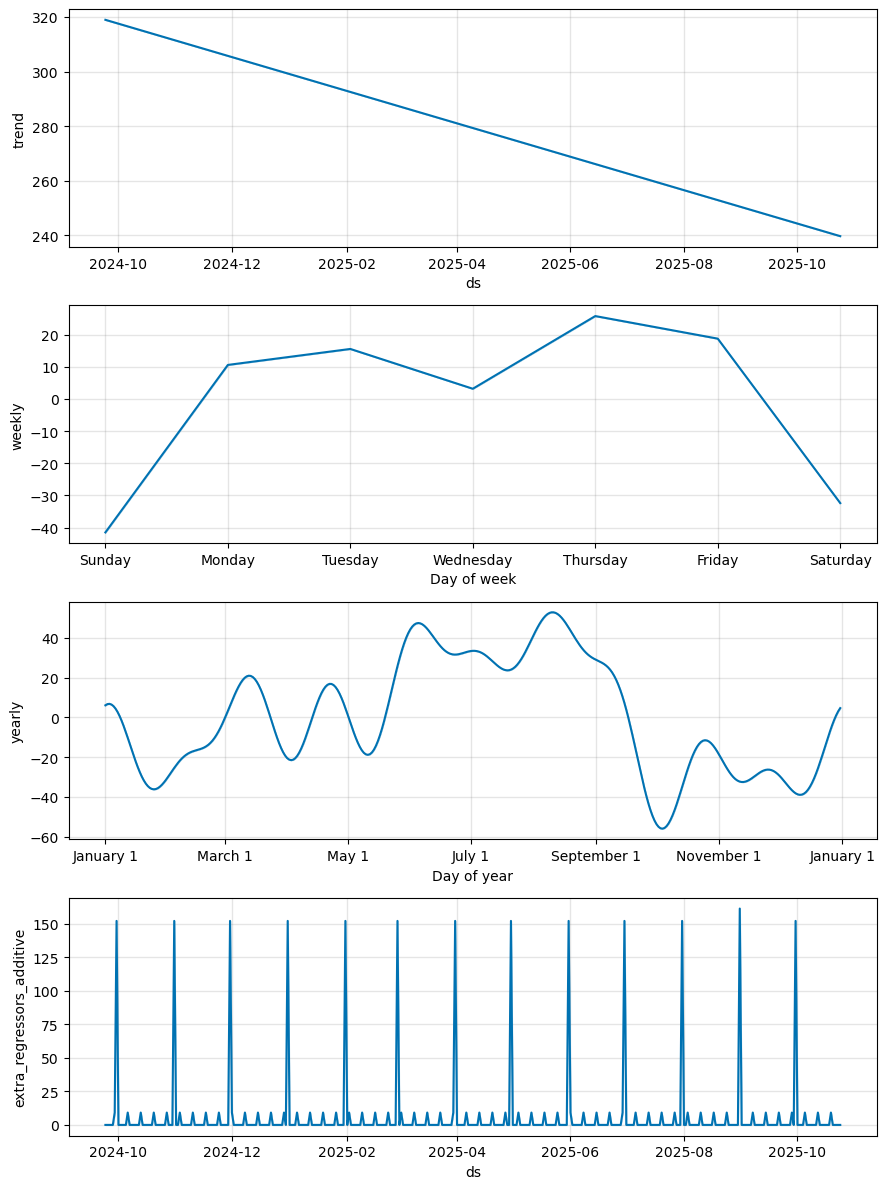

In [16]:
# Visualizing forecast

figure1 = m.plot(forecast)
plot.title('30-Day Cloud Cost Forecast', fontsize=14)
plot.xlabel('Date')
plot.ylabel('Daily Spend (USD)')
plot.show()

figure2 = m.plot_components(forecast)
# plotting components like trend, seasonality and effects of regressors

In [17]:
# Exporting results

forecast_export = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [23]:
forecast_export.head(10)

,ds,yhat,yhat_lower,yhat_upper,y
0,2024-09-24,301.949619,168.934901,436.986084,171.741526
1,2024-09-25,285.166163,142.897248,412.105102,396.065590
2,2024-09-26,303.624414,175.932906,435.186366,323.461202
3,2024-09-27,292.815156,168.301325,427.060213,333.849789
4,2024-09-28,238.311208,106.628913,360.725044,362.647824
5,2024-09-29,235.448817,103.795353,366.427212,309.854388
6,2024-09-30,427.891931,292.204031,563.350347,491.378968
7,2024-10-01,278.920192,144.432712,407.039944,374.479073
8,2024-10-02,265.184929,136.912714,390.556960,248.763511
9,2024-10-03,286.976579,164.818356,420.085555,228.486925


In [20]:
forecast_export = forecast_export.merge(agg_daily[['ds', 'y']], on='ds', how='left')

In [22]:
forecast_export.tail(30)

,ds,yhat,yhat_lower,yhat_upper,y
366,2025-09-25,235.592492,105.652961,370.103382,NaN
367,2025-09-26,224.365684,82.238258,351.803652,NaN
368,2025-09-27,169.369731,41.389212,297.923447,NaN
369,2025-09-28,165.949621,42.654801,293.044541,NaN
370,2025-09-29,205.758555,75.646457,344.345888,NaN
371,2025-09-30,360.173177,227.909265,496.321170,NaN
372,2025-10-01,193.730519,62.069512,325.653226,NaN
373,2025-10-02,214.820091,83.408503,344.003864,NaN
374,2025-10-03,206.861182,66.753941,339.986525,NaN
375,2025-10-04,155.370356,26.888791,287.049063,NaN


In [24]:
forecast_export.to_csv('cloud_cost_forecast30.csv', index=False)

#### Insights:

- The dark blue line is Prophet's predicted mean forecast.
- The light blue shaded area represents the confidence interval.
- The forecast for the next 30 days suggests a stable overall cost trend, not increasing sharply.
- Slight fluctuations can be seen within the same range of 200-400 USD.
- In trend component, we can see a gradual downward slope which means cloud cost is slowly decreasing over time. This could be due to optimizations or improved cost control over the services.
- In weekly seasonality, we can observe high cost spends on Thursday and Friday and low cost on Saturday and Sunday.
- In yearly seasonality, we can observe periodic fluctuations with peak around mid May-July, July-September and a dip can be observed in the mid of September-November.
- The last plot which is our regressor effects shows sharp, regular spikes by external events especially on weekends and month end which may be due to batch job or scheduled activities that consistently drives up the cost on these days.
- Overall, the model predicts the daily spend will range between 170-400 USD for the next 30 days.

In [25]:
# Forecasting for 6 months

future = m.make_future_dataframe(periods=180)
future['is_weekend'] = (future['ds'].dt.weekday > 5).astype(int)
future['is_month_end'] = future['ds'].dt.is_month_end.astype(int)

forecast = m.predict(future)

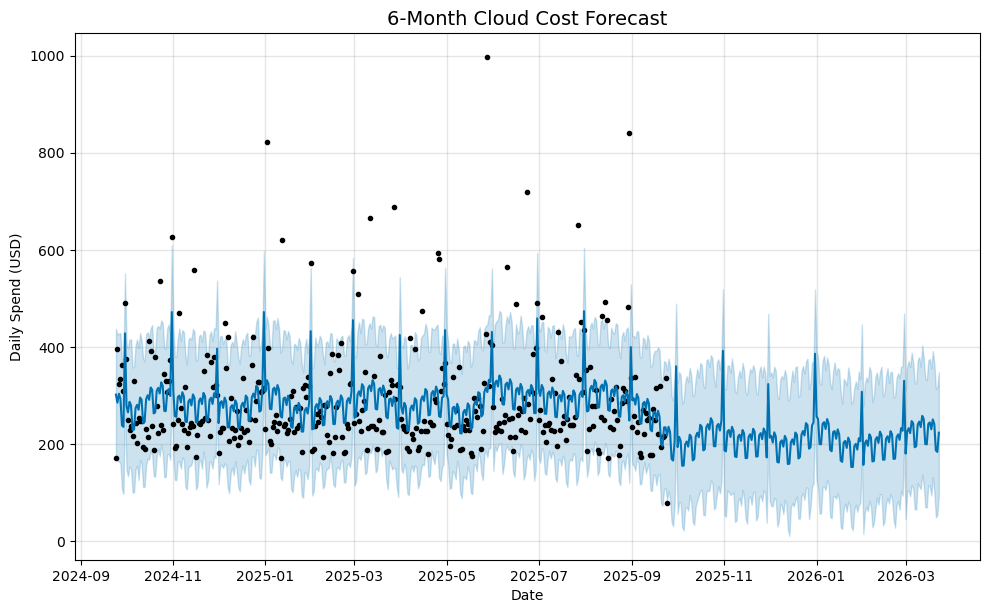

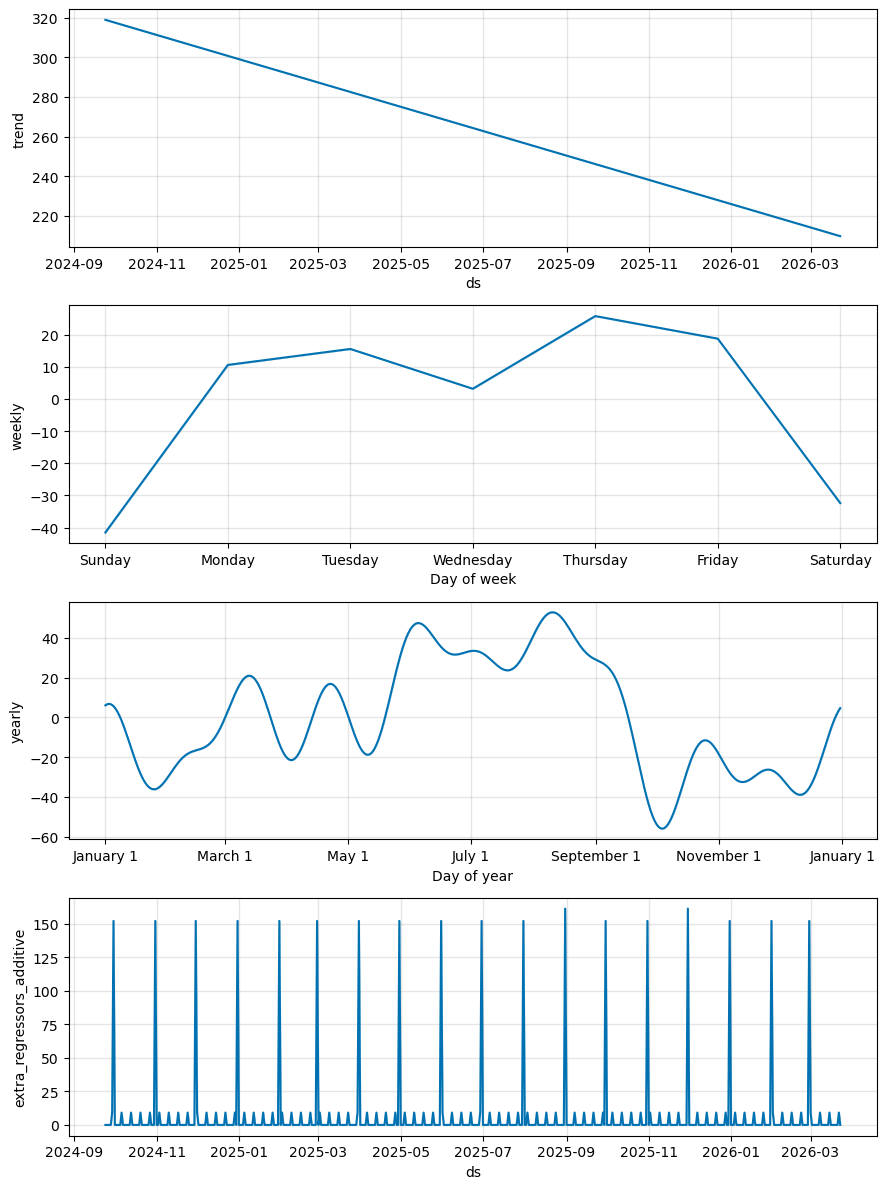

In [26]:
# Visualizing forecast

figure1 = m.plot(forecast)
plot.title('6-Month Cloud Cost Forecast', fontsize=14)
plot.xlabel('Date')
plot.ylabel('Daily Spend (USD)')
plot.show()

figure2 = m.plot_components(forecast)
# plotting components like trend, seasonality and effects of regressors

#### Insights:
- The forecast for 6 months also suggests a stable cost spending with periodic fluctuations but below 400 USD.
- The trend component shows the cost appearing to be decreasing slowly over a period of time.
- Similar observations as that of 30-day can be observed in weekly, yearly and regressor plots.

**Business Interpretation**
- The short-term (30-day forecast) gives IT teams operational visibility: daily fluctuations are expected but controlled, so no urgent risk of cost explosion.
- The medium-term (6-month forecast) provides strategic planning insights: while costs appear to stabilize overall, seasonal peaks must be planned for (e.g., May–July and Sept).
- Clear patterns around weekends and month-end show that business operations drive predictable cost increases which are useful for scheduling and cost optimization.
- Managers can use these forecasts to plan budgets, negotiate cloud contracts, and scale resources before predictable spikes.

In [27]:
forecast_export180 = forecast_export.merge(agg_daily[['ds', 'y']], on='ds', how='left')

In [28]:
forecast_export180.tail(30)

,ds,yhat,yhat_lower,yhat_upper,y_x,y_y
366,2025-09-25,235.592492,105.652961,370.103382,NaN,NaN
367,2025-09-26,224.365684,82.238258,351.803652,NaN,NaN
368,2025-09-27,169.369731,41.389212,297.923447,NaN,NaN
369,2025-09-28,165.949621,42.654801,293.044541,NaN,NaN
370,2025-09-29,205.758555,75.646457,344.345888,NaN,NaN
371,2025-09-30,360.173177,227.909265,496.321170,NaN,NaN
372,2025-10-01,193.730519,62.069512,325.653226,NaN,NaN
373,2025-10-02,214.820091,83.408503,344.003864,NaN,NaN
374,2025-10-03,206.861182,66.753941,339.986525,NaN,NaN
375,2025-10-04,155.370356,26.888791,287.049063,NaN,NaN


In [29]:
forecast_export180.to_csv('cloud_cost_forecast180.csv', index=False)

#### Service-Level Forecasting

In [30]:
service_forecasts = {}

services = df['service_tag'].unique()
services

<StringArray>
['S3', 'EC2', 'EBS', 'ELB', 'Lambda', 'RDS', 'CloudFront', 'EKS']
Length: 8, dtype: string

In [37]:
for service in services:
    df_service = df[df['service_tag']==service]
    agg_service = df_service.groupby(df_service['timestamp'].dt.date)['cost_usd'].sum().reset_index()
    agg_service.columns = ['ds','y']
    agg_service['ds'] = pd.to_datetime(agg_service['ds'])
    
    # add regressors
    agg_service['is_weekend'] = (agg_service['ds'].dt.weekday >= 5).astype(int)
    agg_service['is_month_end'] = agg_service['ds'].dt.is_month_end.astype(int)
    
    # build and fit model
    m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    m.add_regressor('is_weekend')
    m.add_regressor('is_month_end')
    m.fit(agg_service)
    
    # forecast
    future = m.make_future_dataframe(periods=30)
    future['is_weekend'] = (future['ds'].dt.weekday >= 5).astype(int)
    future['is_month_end'] = future['ds'].dt.is_month_end.astype(int)
    forecast = m.predict(future)
    
    # save results
    out = forecast[['ds','yhat','yhat_lower','yhat_upper']]
    out = out.merge(agg_service[['ds','y']], on='ds', how='left')
    out['service_tag'] = service
    service_forecasts[service] = out

09:26:17 - cmdstanpy - INFO - Chain [1] start processing
09:26:17 - cmdstanpy - INFO - Chain [1] done processing
09:26:17 - cmdstanpy - INFO - Chain [1] start processing
09:26:17 - cmdstanpy - INFO - Chain [1] done processing
09:26:18 - cmdstanpy - INFO - Chain [1] start processing
09:26:18 - cmdstanpy - INFO - Chain [1] done processing
09:26:18 - cmdstanpy - INFO - Chain [1] start processing
09:26:18 - cmdstanpy - INFO - Chain [1] done processing
09:26:18 - cmdstanpy - INFO - Chain [1] start processing
09:26:18 - cmdstanpy - INFO - Chain [1] done processing
09:26:19 - cmdstanpy - INFO - Chain [1] start processing
09:26:19 - cmdstanpy - INFO - Chain [1] done processing
09:26:19 - cmdstanpy - INFO - Chain [1] start processing
09:26:19 - cmdstanpy - INFO - Chain [1] done processing
09:26:19 - cmdstanpy - INFO - Chain [1] start processing
09:26:19 - cmdstanpy - INFO - Chain [1] done processing


In [38]:
service_forecast_df = pd.concat(service_forecasts.values(), ignore_index=True)
service_forecast_df.to_csv("service_level_forecasts.csv", index=False)

print("Service-level forecasts exported!")

Service-level forecasts exported!


In [39]:
service_forecast_df.tail(30)

,ds,yhat,yhat_lower,yhat_upper,y,service_tag
3138,2025-09-25,30.034706,8.081285,51.312062,NaN,EKS
3139,2025-09-26,23.767439,0.574088,44.330451,NaN,EKS
3140,2025-09-27,21.321444,-1.106909,43.906528,NaN,EKS
3141,2025-09-28,24.096183,1.193802,46.302415,NaN,EKS
3142,2025-09-29,25.911072,4.491759,48.997098,NaN,EKS
3143,2025-09-30,40.319066,18.816432,61.623773,NaN,EKS
3144,2025-10-01,30.128487,7.940567,52.022511,NaN,EKS
3145,2025-10-02,34.820552,13.045054,55.499202,NaN,EKS
3146,2025-10-03,28.821382,5.530910,52.944125,NaN,EKS
3147,2025-10-04,26.605490,4.620685,49.847148,NaN,EKS


In [40]:
service_forecast_df[service_forecast_df['service_tag'] == 'RDS'].tail(30)

,ds,yhat,yhat_lower,yhat_upper,y,service_tag
2346,2025-09-25,91.829397,-19.945906,197.570909,NaN,RDS
2347,2025-09-26,80.771505,-23.429078,175.637647,NaN,RDS
2348,2025-09-27,52.621380,-49.992972,147.788477,NaN,RDS
2349,2025-09-28,61.816608,-41.574521,165.111725,NaN,RDS
2350,2025-09-29,65.223387,-43.674625,172.515276,NaN,RDS
2351,2025-09-30,126.008704,29.695060,229.278678,NaN,RDS
2352,2025-10-01,68.316752,-36.938536,175.272348,NaN,RDS
2353,2025-10-02,81.162960,-9.497243,187.917597,NaN,RDS
2354,2025-10-03,71.634925,-32.001723,166.700942,NaN,RDS
2355,2025-10-04,45.141372,-53.816586,151.110731,NaN,RDS


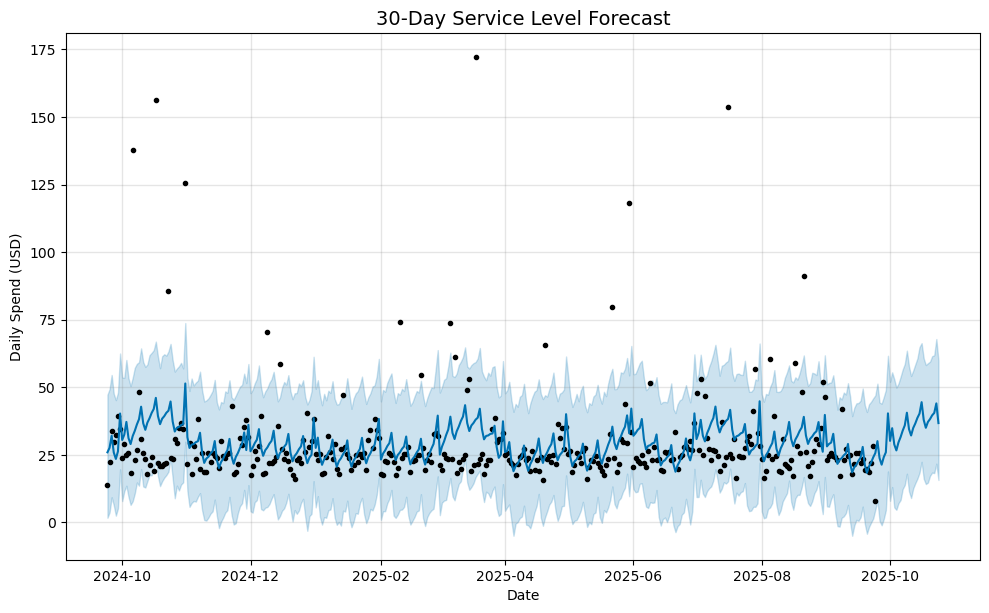

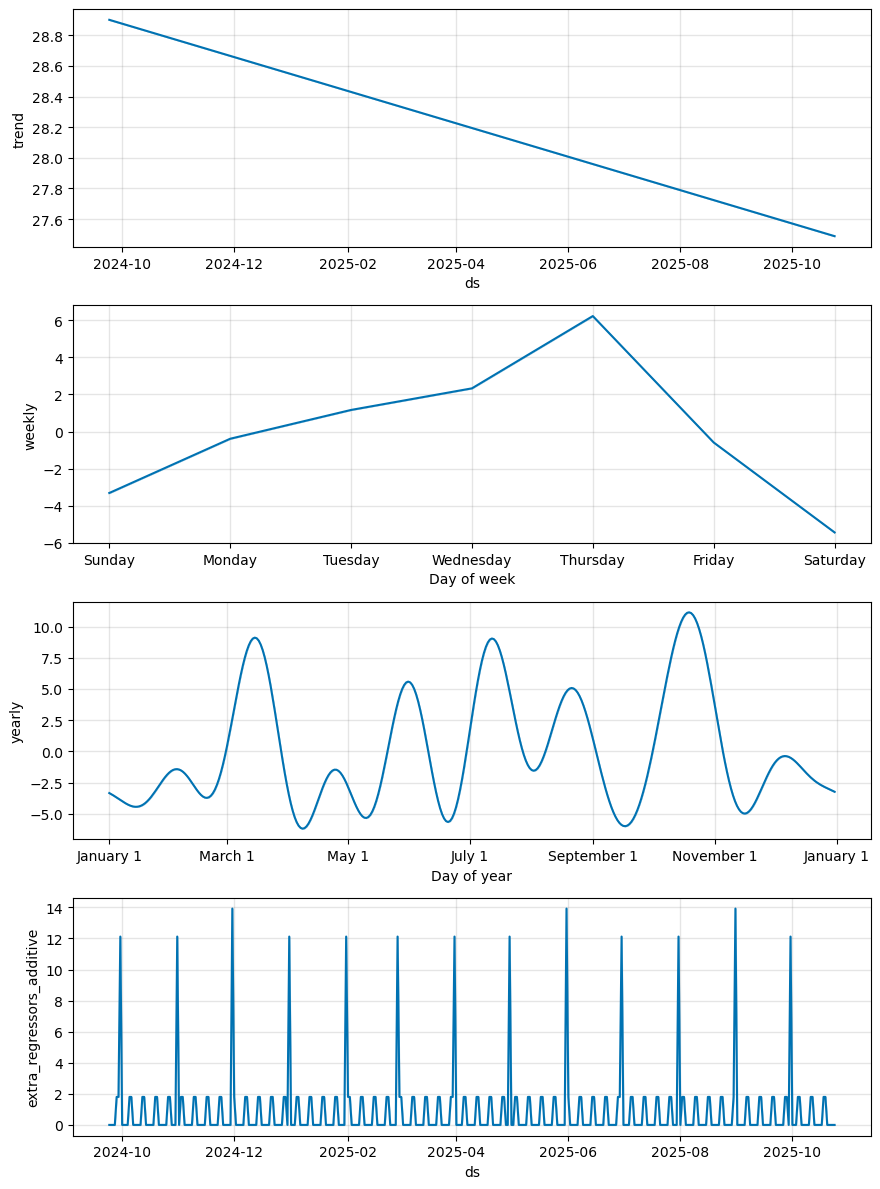

In [41]:
# Visualizing forecast

figure1 = m.plot(forecast)
plot.title('30-Day Service Level Forecast', fontsize=14)
plot.xlabel('Date')
plot.ylabel('Daily Spend (USD)')
plot.show()

figure2 = m.plot_components(forecast)
# plotting components like trend, seasonality and effects of regressors